# Neural ODE & SDE models
---

Цели:
- Познакомиться с Нейронными ОДУ
- Познакомиться с Нейронными СДУ
- Узнать, где их можно использовать

Содержание:
- Neural ODE
    - Введение

Ссылки:
1. [Neural Ordinary Differential Equations](https://arxiv.org/pdf/1806.07366.pdf)
2. [Знакомство с Neural ODE](https://habr.com/ru/companies/ods/articles/442002/)
3. [Efficient and Accurate Gradients for Neural SDEs](https://arxiv.org/pdf/2105.13493.pdf)
4. [Neural Controlled Differential Equations for Irregular Time Series](https://arxiv.org/abs/2005.08926)

Используемые пакеты:
1. [Репо torchdiffeq](https://github.com/rtqichen/torchdiffeq/)
2. [Репо torchsde](https://github.com/google-research/torchsde/)

## Neural ODE

### Введение

В 2018 году вышла статья [Neural Ordinary Differential Equations](https://arxiv.org/abs/1806.07366) и взяла **BEST PAPER AWARD** на *NeurIPS*. В чем была основная идея и какие проблемы решала данная статья?

Рассмотрим простую рекурентную сеть, которая генерирует дискретные временные последовательности
$$
h_{t+1} = h_t + f(h_t, \theta_t)
$$
где $t=0,\dots,T$ — переменная дискретного времени и $h_t\in\mathbb{R}^D$ — состояния модели на $t$-ом шаге.

Вопрос: Что будет, если мы увеличим число слоев и уменьшим размер шага по времени? В пределе получим, что данное представление соответствует ОДУ первого порядка
$$
\dfrac{dh(t)}{dt} = f(h(t), t, \theta)
$$
зная значение функции $h(t)$ в начальный момент времени $h(0)$, мы можем получить его значение $h(T)$ решив задачу Коши
$$
\begin{cases}
\dfrac{dh(t)}{dt} = f(h(t), t, \theta)\\
h(0) = h_0
\end{cases}
$$
решить которую мы можем численно. 

При этом по авторы статьи выделяют следующие плюсы
- **Эффективность по памяти:** Авторы предлагают более эфективный способ рассчета обратного распространения ошибки нежели стандартный.

- **Адаптивные вычисления:** Варьируя методы решения задачи Коши ОДУ можно балансировать между сложностьи вычислений и невязкой (ошибкой метода).

- **Скалируемые и инвертируемые нормализующие потоки:** Авторы показывают, как можно упростить модель NF [рассмотрим в следующей лекции].

- **Непрерывные во времени модели временных динамик:** Очевидно, что благодаря подходу можно обучать сети, моделирующие непрерывные динамические системы.

### Методы решения ОДУ

Рассмотрим задачу Коши первого порядка обыкновенного дифференциального уравнения

$$
\begin{cases}
\dfrac{dy(t)}{dt} = f(y(t), t) \\
y(t_0) = y_0
\end{cases}
$$
Можно преодразовать уравнение как
$$
\dfrac{dy(t)}{dt} = f(y(t), t)\Rightarrow dy(t) = f(y(t), t)dt
$$
Возьмем интеграл для некоторого отрезка $[t, t+h]$ с шагом $h$
$$
\int\limits_t^{t+h} dy(t) = \int\limits_t^{t+h}f(y(t), t)dt \Rightarrow y(t+h) - y(t) = \int\limits_t^{t+h}f(y(t), t)dt
$$
Тогда решение принимает вид
$$
y(t+h) = y(t) + \int\limits_t^{t+h}f(y(t), t)dt \Rightarrow y(t+h) = y(t) + \int\limits_0^{h}f(y(t + x), t)dx
$$
Далее численные решения задачи бедет отличаться тем, как мы будем аппроксимировать численное вычисление оставшегося интеграла $\int_t^{t+h}f(y(t), t)dt$.

#### Явные методы Рунге-Кутты

<figure>
<img src="../.github/images/w12/left-rects.png" alt="Метод аппроксимации интеграла левыми прямоугольниками">
<figcaption align = "center">Метод аппроксимации интеграла левыми прямоугольниками</figcaption>
</figure>

Аппроксимируем интеграл по методу левых прямоугольников, тогда
$$
\int\limits_{0}^{h} f(y, t+x) dx \approx hf(y, t) + O(h^2)
$$
это можно расписать в виде рекурентной формы на сетке фиксированного шага ширины $h$
$$
y_{i+1} = y_i + hf(y_i, t_i)
$$
этот метод называется методом Эйлера, также извыстным как метод Рунге-Кутты 1-го порядка. На всем интервале имеет ошибку $O(h)$, а на шаге $O(h^2)$.

<figure>
<img src="../.github/images/w12/trap.png" alt="Метод аппроксимации интеграла трапециями">
<figcaption align = "center">Метод аппроксимации интеграла трапециями</figcaption>
</figure>

Теперь попробуем построить более сложную аппроксимацию, возьмем для этого метод трапеций
$$
\int\limits_{0}^{h} f(y, t+x) dx \approx \dfrac{h}{2}(f(y(t+h), t+h) + f(y(t), t)) + O(h^3)
$$
однако $y(t+h)$ мы не знаем, но можем посчитать методом Эйлера, тогда 
$$
\begin{align*}
y^*(t+h) & = y(t) + hf(y(t), t) \\
y^*(t+h) & = \dfrac{h}{2}(f(y^*(t+h), t+h) + f(y(t), t)) + O(h^3)
\end{align*}
$$
тогда рекурентная форма будет
$$
\begin{align*}
y^*_{i+1} & = y_i + hf(y_i, t_i) \\ 
y_{i+1} & = y_i + \dfrac{h}{2}(f(y^*_{i+1}, t_{i+1}) + f(y_i, t_i)) + O(h^3)
\end{align*}
$$
то есть речь идет о некоторой корректировке изначального прогноза. Такой метод называется методом Эйлера с пересчетом. Встает вопрос, что если использовать не один пересчет, а несколько, тогда получим
$$
\begin{align*}
y_{i+1}^0 & = y_i + hf(y_i, t_i) \\ 
y_{i+1}^{k+1} & = y_i + \dfrac{h}{2}(f(y^k_{i+1}, t_{i+1}) + f(y_i, t_i)) + O(h^3)
\end{align*}
$$
где $k>0$ и выбирается волевым образом.

В общем виде явный метод Рунге-Кутты имеет вид
$$
\begin{align*}
y_{i+1} & = y_i + h\sum\limits_{j=1}^sb_jk_j \\
k_j & = f(y_i + h\sum_{n=1}^{j-1} a_{jn}k_n, t_i + c_jh)
\end{align*}
$$
где $\sum_{j=1}^s b_j = 1$, $\sum_{n=1}^{j-1}a_{jn} = c_j$, то есть речь идет о вычислении на шаге постепенном вычислении промежудочных шагов отрезка $[t, t+h]$. Метод называется явным, так как формула рассчета выводится "явно". Примером явного метода Рунге-Кутты большего порядка является метод 4-го порядка
$$
\begin{align*}
y_{i+1} & = y_i + \dfrac{h}{6}(k_1 + 2k_2 + 2k_3 + k_4) + O(h^5)\\
k_1 & = f(y_i, t_i) \\
k_2 & = f(y_i + \dfrac{h}{2}k_1, t_i + \dfrac{h}{2}) \\
k_3 & = f(y_i + \dfrac{h}{2}k_2, t_i + \dfrac{h}{2}) \\
k_4 & = f(y_i + hk_3, t_i + h) \\
\end{align*}
$$

#### Неявный метод Рунге-Кутты

<figure>
<img src="../.github/images/w12/right-rects.png" alt="Метод аппроксимации интеграла правыми прямоугольниками">
<figcaption align = "center">Метод аппроксимации интеграла правыми прямоугольниками</figcaption>
</figure>

Аппроксимируем интеграл методом правых прямоугольников, тогда
$$
\int\limits_{0}^{h} f(y, t+x) dx \approx hf(y(t+h), t+h) + O(h^2)
$$
в рекурентной форме получим
$$
y_{i+1} = y_i + hf(y_{i+1}, t_{i+1})
$$
это __неявный метод Эйлера__. Полученное уравнение имеет вид нелинейного алгебраического уравнения и может быть решена методом простых итераций или методом Ньютона.

В общем виде неявный метод Рунге-Кутты имеет вид
$$
\begin{align*}
y_{i+1} & = y_i + h\sum\limits_{j=1}^sb_jk_j \\
k_j & = f(y_i + h\sum_{n=1}^{s} a_{jn}k_n, t_i + c_jh)
\end{align*}
$$
методы этой группы более сложные с точки зрения вычислений, однако обладают большей устойчивостью в сранении с явными.

#### Метод Адамса

До этого мы рассматривали методы где в вычислениях используется одна точка. Встает вопрос, что если использовать для рассчетов несколько точек в качестве некоторого исторического периода динамики решения. Семейства таких методов называется методами Адамса.
$$
y_{i+1} = y_i + h\sum\limits_{j=0}^k u_{j}f(y_{i-j}, t_{i-j})
$$
получим метод Адамса-Башфорта. При различном выборе $k$ полчим разные схемы. Так, при $k=0$
$$
y_{i+1} = y_i + hu_0f(y_{i}, t_{i})~\text{— метод Эйлера при}~u_0=1
$$
после получения второй точки методом Эйлера возьмем $k=1$
$$
y_{i+1} = y_i + hu_0f(y_{i}, t_{i}) + hu_1f(y_{i-1}, t_{i-1})
$$
и так далее.
Неявный метод имеет вид 
$$
y_{i+1} = y_i + h\sum\limits_{j=-1}^{k-1} u_{j}f(y_{i-j}, t_{i-j})
$$
и называется метод Адамса-Мультона.

Так как для вычисления методом Адамса $k$-го порядка требуется иметь $k$ первых точек, их обычно вычисляют методом Рунге-Кутты.

|Название | Вид | Точность шага | Точность на отрезке |
|:--------|:--------------------:|:-------------:|:-------------------:|
|Явный метод Эйлера| $$y_{i+1} = y_i + hf(y_i, t_i)$$ | $O(h^2)$ | $O(h)$ |
|Невный метод Эйлера| $$y_{i+1} = y_i + hf(y_{i+1}, t_{i+1})$$ | $O(h^2)$ | $O(h)$ |
|Явный метод Эйлера с пересчетом| $$ y_{i+1}^0 = y_i + hf(y_i, t_i)\\ y_{i+1}^{k+1} = y_i + \dfrac{h}{2}(f(y^k_{i+1}, t_{i+1}) + f(y_i, t_i)) $$ | $O(h^3)$ | $O(h^2)$ |
|Явный метод Рунге-Кутты 4-го порядка| $$ y_{i+1} = y_i + \frac{h}{6}(k_1 + 2k_2 + 2k_3 + k_4) \\ k_1 = f(y_i, t_i)\\ k_2 = f(y_i + k_1\frac{h}{2}, t_i+\frac{h}{2})\\ k_3 = f(y_i + k_2\frac{h}{2}, t_i+\frac{h}{2})\\ k_4 = f(y_i + k_3h, t_i+h) $$ | $O(h^5)$ | $O(h^4)$ |
|Метод Адамса-Башфорта| $$y_{i+1} = y_i + h\sum\limits_{j=0}^k u_{j}f(y_{i-j}, t_{i-j})$$ | $O(h^{k+1})$ | $O(h^k)$ |
|Метод Адамса-Мультона| $$y_{i+1} = y_i + h\sum\limits_{j=-1}^{k-1} u_{j}f(y_{i-j}, t_{i-j})$$ | $O(h^{k+1})$ | $O(h^k)$ |

### Процесс обучения нейронных ОДУ

Возьмем в качестве производной $f$ функцию $f(z(t), t, θ)$, параметризованную функцию некоторого семейства параметризованных функций (например нейронную сеть). Тогда при наличии множества пар $\{z_i, t_i\}_{i=0}^N$ можно аппроксимировать неизвестную нам функцию $f(z(t), t)$ функцией $f(z(t), t, θ)$. Делать мы это будем решая уравнение методом решения ОДУ $ODESolver$ и вычисляя функцию потерь
$$
L(z_N) = L(ODESolver(z_0, f_θ, t_0, t_N, θ))\to\min\limits_{θ}
$$

Далее нужно посчитать обратное распространение ошибки. Современные фреймворки позволяют автоматически рассчитывать обратное распространение, однако авторы метода предлагают воспользоваться свойством ОДУ, позволяющим вычислять уравнение в обратном направлении дл ускорения рассчетов.

Для рассчета обратного распространения необходимо рассчитать градиенты по всем параметрам $z_0$, $t_0$, $t_N$, $θ$. Для их рассчета предлагается параметризация градиентов через переменную $a(t)$
$$
a(t) = -\dfrac{∂L}{∂z(t)}
$$

Эта переменная назыается сопряженным (adjoint) состоянием. Ее градиент рассчитывается как
$$
\dfrac{da(t)}{dt} = -a(t)\dfrac{∂ f(z(t), t, θ)}{∂ z}
$$

Вывод этой формулы предагается в оригинальной статье и вычисляется через сложную производную (chain rule). С помощью этой параметризации градиент для обратного распространения ошибки сводится к решению ОДУ в обратную сторону
$$
\dfrac{∂L}{∂z(t_0)} = \int\limits_{t_N}^{t_0} a(t)\dfrac{∂ f(z(t), t, θ)}{∂ z}dt
$$
Рассчет градиентов $t$ и $θ$ можно расчитать как часть состояния. Такое состояние завется аугментированным.
$$
\dfrac{d}{dt}
\begin{bmatrix}
z \\ θ \\ t
\end{bmatrix} (t) = f_{aug}([z, θ, t]) =
\begin{bmatrix}
f(z(t), t, θ) \\ 0 \\ 1
\end{bmatrix}
$$
Тогда сопряженное состояние к этому аугментированному состоянию
$$
a_{aug} =
\begin{bmatrix}
a \\ a_θ \\ a_t
\end{bmatrix},~
a_θ(t) = \dfrac{∂L}{∂θ(t)},~a_t(t) = \dfrac{∂L}{∂t(t)}
$$
Градиент аугментированной динамики
$$
\dfrac{da_{aug}}{dt} = -
\begin{bmatrix}
a\frac{∂f}{∂z} & a\frac{∂f}{∂θ} & a\frac{∂f}{∂t}
\end{bmatrix}^T
$$

Решение этого ОДУ назад во времени дает градиенты по всем входным параметрам в решатель ОДУ и могут быть вычислены за один проход метода $ODESolver$
$$
\begin{cases}
\dfrac{∂L}{∂z(t_0)} = \int\limits_{t_N}^{t_0} a(t) \dfrac{∂f(z(t), t, θ)}{∂z}dt \\
\dfrac{∂L}{∂θ} = \int\limits_{t_N}^{t_0} a(t) \dfrac{∂f(z(t), t, θ)}{∂θ}dt \\
\dfrac{∂L}{∂t_0} = \int\limits_{t_N}^{t_0} a(t) \dfrac{∂f(z(t), t, θ)}{∂t}dt \\
\dfrac{∂L}{∂t_N} = -a(t) \dfrac{∂f(z(t), t, θ)}{∂t}dt \\
\end{cases}
$$
Ниже приведена иллюстрация прямого и обратного распространения ошибки в нейронных ОДУ.
<figure>
<img src="https://habrastorage.org/r/w1560/webt/7e/65/hf/7e65hfxs1amdqyy_uy6emdwulkg.png" alt="Примеры схем генеративных моделй">
<figcaption align = "center">Схема прямого и обратного распространения ошибки нейронных ОДУ</figcaption>
</figure>
Также представлен алгоритм рассчета обратного распространения ошибки.
<figure>
<img src="https://habrastorage.org/r/w1560/webt/8k/pz/uk/8kpzukmizpmezmywov4b3zm29lc.png" alt="Примеры схем генеративных моделй">
<figcaption align = "center">Алгоритм вычисления обратного распространения ошибки</figcaption>
</figure>

### Примеры использования

Рассмотрим простое ОДУ вида
$$
\begin{cases}
    \dfrac{dy(t)}{dt} = yA
    y(0) = y_0
\end{cases}
$$
где $A=\begin{bmatrix} -0.1 & -1 \\ 1 & -0.1 \end{bmatrix}$, $y_0 = \begin{bmatrix} 0.6 & 0.3 \end{bmatrix}$.

In [ ]:
!pip install torchdiffeq

In [1]:
import random
import shutil
import imageio.v2 as imageio

from pathlib import Path
from tqdm.notebook import tqdm

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchdiffeq import odeint_adjoint as odeint

In [2]:
class Lambda(nn.Module):
    """Истинная производная по времени процесса
    """
    def __init__(self, A):
        super().__init__()
        self.A = A
    def forward(self, t, y):
        return torch.mm(y, self.A)


Так как наш процесс явно не зависит от времени, то можно насэмплировать батчи как отрезки равной длины исходного процесса.

In [3]:
def get_batch(y, t, batch_time=8, batch_size=256):
    """Генератор батчей
    y: torch.Tensor
        Значения целевой переменной
    t: torch.Tensor
        Значения времени
    batch_time: int
        Длина временного отрезка
    batch_size:
        Размер батча
    """
    size = len(t)
    start = np.random.randint(size-batch_time, size=batch_size)
    y0 = y[start]
    t0 = np.random.randint(size-batch_time)
    ts = t[t0:t0+batch_time]
    ys = torch.stack([y[start + i] for i in range(batch_time)], dim=0)
    return y0, ts, ys


In [4]:
class ODEF(nn.Module):
    """Обучаемая сеть
    """
    def __init__(self):
        super().__init__()
        self.net = nn.Linear(2, 2, bias=False)
        nn.init.normal_(self.net.weight)

    def forward(self, t, y):
        return self.net(y)


In [5]:
def plot(func, y, y0, t, epoch: int = None):
    y_pred = odeint(func, y0, t, method='rk4')[:, 0]

    plt.figure(figsize=(12, 3))

    ax = plt.subplot(1, 3, 1)
    ax.set_title('Фазовый портрет')
    ax.plot(y_pred.detach()[:, 0].cpu(), y_pred.detach()[:, 1].cpu(), c='r')
    ax.scatter(y.detach()[:, 0].cpu(), y.detach()[:, 1].cpu(), s=1, c='k', alpha=0.7)
    ax.set_ylim(-1, 1)
    ax.set_xlim(-1, 1)
    ax.set_xlabel('$y_1$')
    ax.set_ylabel('$y_2$')

    ax = plt.subplot(1, 3, 2)
    ax.set_title('Траектории')
    ax.plot(t.cpu(), y_pred.detach()[:, 0].cpu())
    ax.plot(t.cpu(), y_pred.detach()[:, 1].cpu())
    ax.scatter(t.cpu(), y.detach()[:, 0].cpu(), s=1, alpha=0.7)
    ax.scatter(t.cpu(), y.detach()[:, 1].cpu(), s=1, alpha=0.7)
    ax.set_xlabel('$t$')
    ax.set_ylabel('$y_1$, $y_2$')
    ax.set_xlim(t.cpu().min(), t.cpu().max())
    ax.set_ylim(-1, 1)

    ax = plt.subplot(1, 3, 3)
    Y, X = np.mgrid[-1:1:21j, -1:1:21j]
    dydt = func(0, torch.Tensor(np.stack([X, Y], -1).reshape(21 * 21, 2)).to(device)).cpu().detach().numpy()
    mag = np.sqrt(dydt[:, 0]**2 + dydt[:, 1]**2).reshape(-1, 1)
    dydt = (dydt / mag)
    dydt = dydt.reshape(21, 21, 2)

    ax.set_title('Векторное поле обучения')
    ax.streamplot(X, Y, dydt[:, :, 0], dydt[:, :, 1], color="black")
    ax.set_xlabel('$y_1$')
    ax.set_ylabel('$y_2$')
    ax.set_ylim(-1, 1)
    ax.set_xlim(-1, 1)

    plt.tight_layout()
    if epoch is None:
        plt.show();
    else:
        plt.savefig('imgs/{:04d}'.format(epoch));
        plt.clf();
        plt.close();


In [6]:
Path('imgs').mkdir(exist_ok=True)

random.seed(0);
np.random.seed(0);
torch.manual_seed(0);
torch.cuda.manual_seed(0);
torch.cuda.manual_seed_all(0);

epoches = 500
batch_size = 256
batch_time = 8
t0, t1, time_size = 0, 20, 200
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

y0 = torch.Tensor([[0.6, 0.3]]).to(device)
t = torch.linspace(t0, t1, time_size).to(device)
A = torch.Tensor([[-0.1, -1.], [1., -0.1]]).to(device)

# Находим таргет
y = odeint(Lambda(A), y0, t, method='rk4')[:, 0]
# Добавим шума в таргет
y = y + 0.01 * torch.randn(y.size(), device=device)

func = ODEF().to(device)
optimizer = torch.optim.Adam(func.parameters(), lr=0.01)

pbar = tqdm(total=epoches)
with pbar:
    for i in range(epoches):
        # Обнулем градиенты
        optimizer.zero_grad()
        # Берем батч
        y0, ts, ys = get_batch(y, t)
        # Делаем прогноз
        y_pred = odeint(func, y0, ts, method='rk4').to(device)
        # Считаем MSE
        loss = torch.mean(torch.abs(y_pred - ys))
        # Рассчитываем градиенты
        loss.backward()
        # Делаем шаг обучения
        optimizer.step()

        pbar.update(1)
        pbar.set_description("Epoch: %i, Loss: %.3f" % (i, loss.item()))

        with torch.no_grad():
            # отрисуем результат на каждом 20-м шаге
            if (i % 20) == 0:
                y0 = torch.Tensor([[0.6, 0.3]]).to(device)
                plot(func, y, y0, t, i);

    with torch.no_grad():
        # отрисуем финальный результат
        y0 = torch.Tensor([[0.6, 0.3]]).to(device)
        plot(func, y, y0, t, epoches);

# Делаем GIF'ку
images = []
filenames = sorted(list(Path('imgs/').glob('*.png')))
for filename in filenames:
    images.append(imageio.imread(str(filename)))
imageio.mimsave('simple_ode.gif', images, duration=5, format='GIF')
shutil.rmtree('imgs')


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


![alt](../.github/simple_ode.gif)

Теперь сэмплируя разные значения $y_0$ можем построить множество процессов одного семейства.

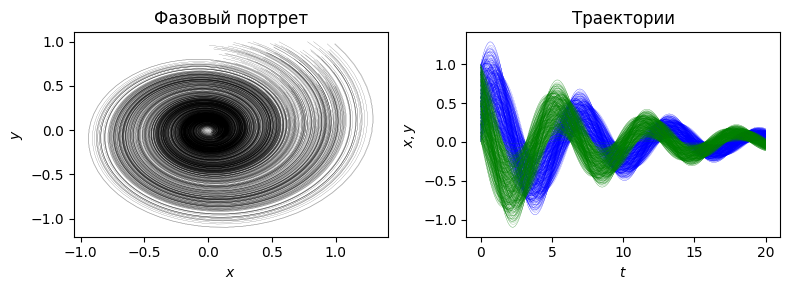

In [150]:
with torch.no_grad():
    y0 = torch.rand((300, 2)).to(device)
    t = torch.linspace(0., 20., 200).to(device)

    x, y = odeint(func, y0, t, method='rk4').transpose(0, -1).cpu()
    x, y = x.T, y.T

fig, ax = plt.subplots(ncols=2, figsize=(8, 3))
ax[0].plot(x, y, c='k', linewidth=0.1)
ax[0].set_title('Фазовый портрет')
ax[0].set_xlabel('$x$')
ax[0].set_ylabel('$y$')
ax[1].plot(t.cpu(), x, c='b', linewidth=0.1)
ax[1].plot(t.cpu(), y, c='g', linewidth=0.1)
ax[1].set_title('Траектории')
ax[1].set_xlabel('$t$')
ax[1].set_ylabel('$x, y$')

plt.tight_layout()
plt.show()

## Neural SDE

После выхода статьи NODEs в 2018 году ресерчеры осознали, что если моделировать сетями можно ОДУ, то значит можно и другие ДУ тоже моделировать через параметризацию нейронными сетями. Тогда в январе 2020 года [Scalable Gradients for Stochastic Differential Equations](https://arxiv.org/pdf/2001.01328.pdf) (AISTATS) вышла статья, которая рассматривает моделирование СДЕ. 

Рассмотрим задачу Коши уравнения 
$$
\begin{cases}
dz(t) = \mu(z(t), t, \theta)dt + \sigma(z(t), t, \theta)dW(t), \\
z(t_0) = z_0
\end{cases}
$$
где $\mu$ — функция дрейфа, $\sigma$ — диффузии, $dW$ — многомерное Броуновское движение.

Для решения этого уранвения можно прибегнуть к "трюку"
$$
dz(t) = \mu(z(t), t, \theta)dt + \sigma(z(t), t, \theta)dW(t) \Rightarrow \dfrac{dz(t)}{dt} = \mu(z(t), t, \theta) + \sigma(z(t), t, \theta)\dfrac{dW(t)}{dt}
$$
что уже можно решать как задачу Коши ОДУ, например явным метолом Эйлера
$$
z_{i+1} = z_i + h\cdot\mu(z(t), t, \theta) + \sigma(z(t), t, \theta)\Delta{W_i}
$$

Но есть проблемы:
1. Как считать градиенты также эффективно как и для ОДУ?
2. Как хранить и скалировать $dW(t)$ эффективно?

### Сопряженные состояния SDE и воспроизводимый шум
![adjoint](../.github/images/w12/adjoint.png)

### Виртуальное броуновское дерево

Под броуновским мостом понимается 
$$
w_m = dW(t_m)\sim\mathcal{N}(a + \dfrac{t-t_1}{t_2-t_1}(b-a))
$$
![brownian](../.github/images/w12/brownian_tree.png)

In [ ]:
!pip install torchsde

In [161]:
bm = BrownianInterval(t0=0.0, t1=1.0, size=(2000, ))(0., 1.).cumsum(-1)

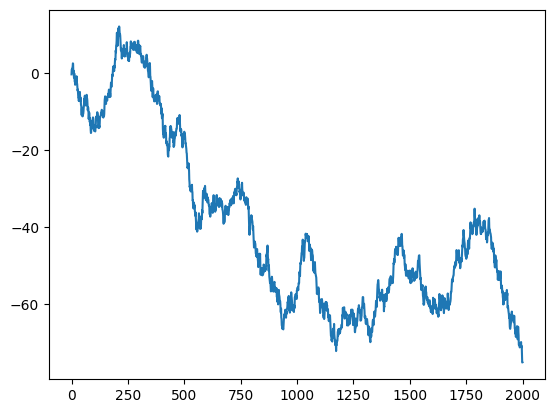

In [164]:
plt.plot(bm);

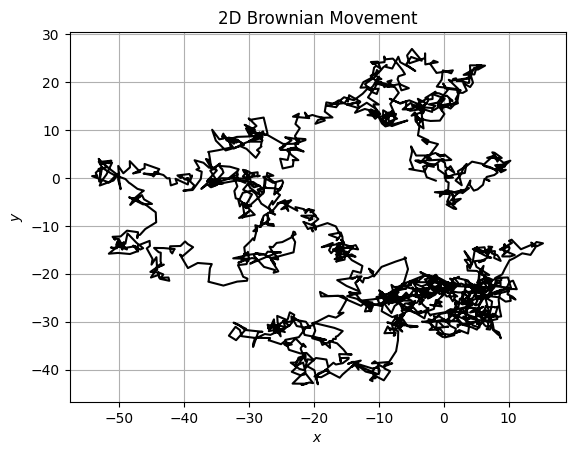

In [152]:
from torchsde import BrownianInterval, sdeint

random.seed(0);
np.random.seed(0);
torch.manual_seed(0);
torch.cuda.manual_seed(0);
torch.cuda.manual_seed_all(0);

bm = BrownianInterval(t0=0.0, t1=1.0, size=(2, 2000))
x, y = bm(0., 1.).cumsum(-1)
plt.plot(x, y, c='k')
plt.grid()
plt.title("2D Brownian Movement")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()

In [54]:
class Lambda(nn.Module):

    def __init__(self, A, B):
        super().__init__()
        self.A = A
        self.noise_type = "diagonal"
        self.sde_type = "ito"

    def f(self, t, y):
        return torch.mm(y, self.A)

    def g(self, t, y):
        return y

In [55]:
class SDEF(nn.Module):

    def __init__(self):
        super().__init__()

        self.noise_type = "diagonal"
        self.sde_type = "ito"

        self.f = nn.Linear(2, 2, bias=False)
        # nn.init.normal_(self.f.weight)

        self.g = nn.Linear(2, 2, bias=False)
        # nn.init.normal_(self.g.weight)

    def f(self, t, y):
        return self.f(y)

    def g(self, t, y):
        return self.g(y)

In [47]:
Path('imgs').mkdir(exist_ok=True)

random.seed(0);
np.random.seed(0);
torch.manual_seed(0);
torch.cuda.manual_seed(0);
torch.cuda.manual_seed_all(0);

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

y0 = torch.Tensor([[0.6, 0.3]]).to(device)
t = torch.linspace(0., 20., 200).to(device)
A = torch.Tensor([[-0.1, -1.], [1., -0.1]]).to(device)

y = sdeint(Lambda(A, A), y0, t, method='euler')[:, 0]
# y = y + 0.01 * torch.randn(y.size(), device=device)

epoches = 500
func = SDEF().to(device)
optimizer = torch.optim.Adam(func.parameters(), lr=0.01)

pbar = tqdm(total=epoches)

with pbar:
    for i in range(epoches):
        optimizer.zero_grad()
        y0, ts, ys = get_batch(y, t)
        y_pred = sdeint(func, y0, ts, method='euler').to(device)
        loss = torch.mean(torch.abs(y_pred - ys))
        loss.backward()
        optimizer.step()

        pbar.update(1)
        pbar.set_description("Epoch: %i, Loss: %.3f" % (i, loss.item()))

        with torch.no_grad():
            if (i % 20) == 0:
                y0 = torch.Tensor([[0.6, 0.3]]).to(device)
                plot(func, y, y0, t, i);

    with torch.no_grad():
        y0 = torch.Tensor([[0.6, 0.3]]).to(device)
        plot(func, y, y0, t, epoches);

images = []
filenames = sorted(list(Path('imgs/').glob('*.png')))
for filename in filenames:
    images.append(imageio.imread(str(filename)))
imageio.mimsave('simple_sde.gif', images, duration=5, format='GIF')
shutil.rmtree('imgs')


KeyboardInterrupt: 

In [117]:
class SDEF(nn.Module):

    def __init__(self, A):
        super().__init__()
        self.A = A
        self.noise_type = "diagonal"
        self.sde_type = "ito"

    def f(self, t, y):
        return torch.mm(self.A, y)

    def g(self, t, y):
        return 0.3 * torch.sigmoid(torch.cos(t) * torch.exp(-y))

In [118]:
batch_size, state_size, t_size = 2, 1, 100
sde = SDEF(A).to(device)
ts = torch.linspace(0., 20., 100).to(device)
y0 = torch.full(size=(batch_size, state_size), fill_value=0.1).to(device)

with torch.no_grad():
    ys = sdeint(sde, y0, ts, method='euler')[:, :, 0]

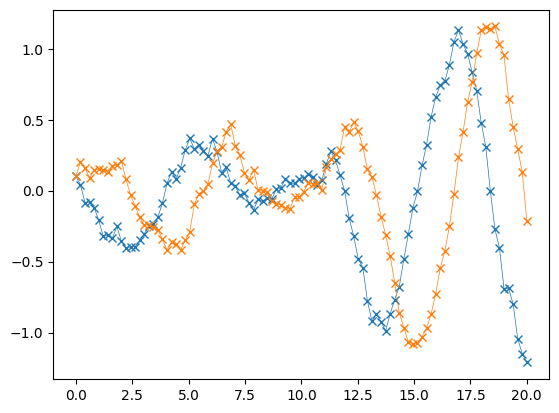

In [124]:
plt.plot(ts.cpu(), ys.cpu(), '-x', linewidth=0.5)
plt.show()

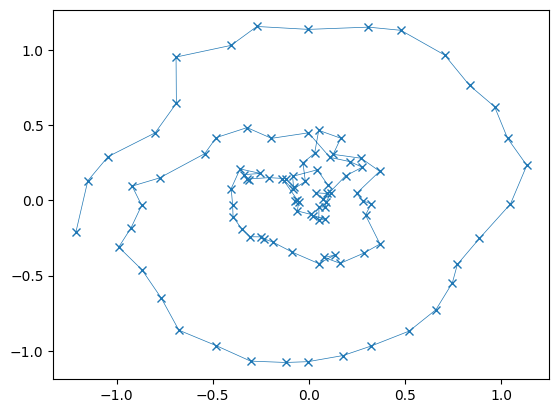

In [123]:
plt.plot(ys[:, 0].cpu(), ys[:, 1].cpu(), '-x', linewidth=0.5)
plt.show()